In [ ]:
# imports used by more than one cell
import logging
import warnings
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm

import geedim as gd

logging.basicConfig(level=logging.ERROR)

In [ ]:
from glob import glob
# source captured from 2010-01-22 - 2010-02-01
src_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Source/'
    'GroundTruthSubset'
)
src_mosaic_path = src_root.joinpath(
    'NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset_Source.vrt'
)
src_paths = [
    Path(src_path) 
    for src_path in glob(str(src_root.joinpath('*_RGBN_CMP.tif')))
]

ref_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Reference/'
    'GroundTruthSubset'
)
l7_ref_path = ref_root.joinpath('l7_comp_ref.tif')
modis_ref_path = ref_root.joinpath('modis_nbar_ref.tif')

# create a search region that covers the source image mosaic
region = gd.utils.get_bounds(src_mosaic_path)


In [ ]:
gd.Initialize()

# create and search the Landsat-7 collection
l7_coll = gd.MaskedCollection.from_name('LANDSAT/LE07/C02/T1_L2')
l7_coll = l7_coll.search(
    '2010-01-01', '2010-02-28', region, cloudless_portion=50
)
print('Image property descriptions:\n\n' + l7_coll.schema_table)
print('\nSearch Results:\n\n' + l7_coll.properties_table)

# equivalent geedim command line:
# !geedim search -c l7-c2-l2 -s 2010-01-01 -e 2010-02-28-cp 50  -r {src_mosaic_path}

In [ ]:
# create a composite of search results to fill in SLE gaps
l7_comp_im = l7_coll.composite(
    gd.CompositeMethod.q_mosaic, date='2010-01-27', 
    resampling=gd.ResamplingMethod.bilinear,
)

# download
with rio.open(src_mosaic_path, 'r') as ds:
    src_crs = ds.crs.to_wkt()

l7_comp_im.download(
    l7_ref_path, crs=src_crs, scale=30, region=region, overwrite=True
)

In [ ]:
# search the MODIS NBAR collection
modis_coll = gd.MaskedCollection.from_name('MODIS/006/MCD43A4')
modis_coll = modis_coll.search(
    '2022-01-27', '2022-01-28', region, 
)
print('Image property descriptions:\n\n' + modis_coll.schema_table)
print('\nSearch Results:\n\n' + modis_coll.properties_table)

# download LANDSAT/LC08/C02/T1_L2/LC08_009057_20220215 
cmp_ref_path = ref_root.joinpath('modis_nbar_ref.tif')
modis_image = gd.MaskedImage.from_id(
    'MODIS/006/MCD43A4/2010_01_27', mask=True
)
modis_image.download(modis_ref_path, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim search -c modis-nbar -s 2010-01-27 -e 2010-01-28 -r {src_mosaic_path} download -o

In [13]:
from homonim import RasterFuse, Model, ProcCrs, utils
# corrected file names corresponding to source names
if False:
    ref_bands = [3, 2, 1, 4]
    cmp_ref_bands = [1, 4, 3, 2]
    ref_path = l7_ref_path
    cmp_ref_path = modis_ref_path
    model = Model.gain_blk_offset
    kernel_shape = (5, 5)
    corr_root = Path(
        'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Corrected/'
        'GroundTruthSubset/L7/'
    )
    ref_sc_off = [12e3, .5]
else:
    ref_bands = [1, 4, 3, 2]
    cmp_ref_bands = [3, 2, 1, 4]
    ref_path = modis_ref_path
    cmp_ref_path = l7_ref_path
    model = Model.gain
    kernel_shape = (3, 3)
    corr_root = Path(
        'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Corrected/'
        'GroundTruthSubset/Modis/'
    )
    ref_sc_off = [1.7e3, .1]
post_fix = utils.create_out_postfix(
    ProcCrs.ref, model=model, kernel_shape=kernel_shape, driver='GTiff'
)
corr_paths = [
    corr_root.joinpath(src_path.stem + post_fix)
    for src_path in src_paths
]


In [ ]:
for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(src_path, ref_path, ref_bands=ref_bands) as raster_fuse:
        print(f'{corr_path.name}:')
        raster_fuse.process(
            corr_path, model, kernel_shape, 
            block_config=dict(threads=2, max_block_mem=256), 
            out_profile=dict(dtype='uint16', nodata=0), 
            model_config=dict(mask_partial=False), 
            overwrite=True
        )
        break

In [ ]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = corr_root.joinpath(
    f'NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset{post_fix[:-4]}.vrt'
)
ds = gdal.BuildVRT(
    str(corr_mosaic_path.absolute()), [str(cp) for cp in corr_paths]
)
ds.FlushCache()

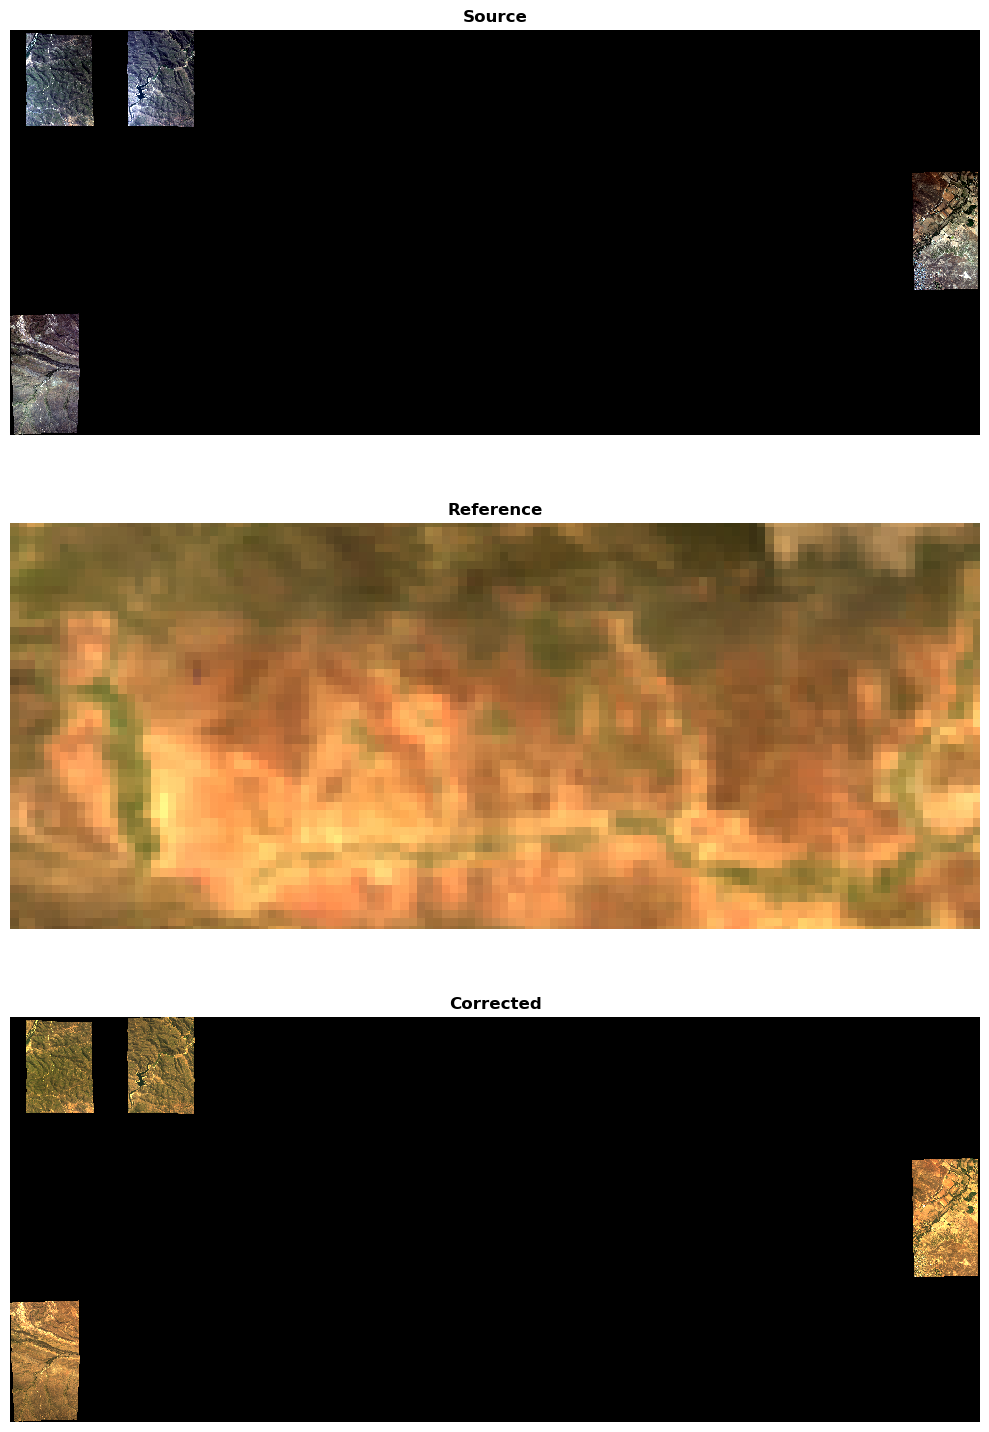

In [10]:
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.plot import show
# VRT mosaic of the source files

with rio.open(src_mosaic_path, 'r') as ds:
    src_crs = ds.crs

fig, axes = pyplot.subplots(
    3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10, 15), 
    dpi=100
)

for im_file, ds_fact, indexes, sc_off, ax, label in zip(
    [src_mosaic_path, ref_path, corr_mosaic_path],
    [16, 1, 16],                           # downsample factor
    [None, ref_bands, None],               # band indices
    [None, ref_sc_off, ref_sc_off],        # colour scale & offset
    axes,
    ['Source', 'Reference', 'Corrected'], 
):
    # read, scale and display the image
    with (rio.open(im_file, 'r')) as ds:

        if ds.crs != src_crs:
            ds = WarpedVRT(ds, crs=src_crs, resampling=Resampling.bilinear)
        with ds:

            ds_shape = tuple(np.round(np.array(ds.shape) / ds_fact).astype('int'))
            transform = ds.transform * rio.Affine.scale(ds_fact)

            array = ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

    # change nodata value to nan
    mask = np.any((array == ds.nodata) | np.isnan(array), axis=(0))
    array[:, mask] = np.nan

    if sc_off is not None:
        # scale and offset pixel values
        array = np.clip((array / sc_off[0]) - sc_off[1], 0, 1)
    else:
        # 'normalise' image 2%-98% -> 0-1
        for bi in range(array.shape[0]):
            array[bi] -= np.nanpercentile(array[bi], 1)
            array[bi] /= np.nanpercentile(array[bi], 99)
            array[bi] = np.clip(array[bi], 0, 1)
    # if im_file == ref_path:
    #     break

    ax = show(array[0:3], transform=transform, interpolation='nearest', ax=ax)

    ax.set_title(label, fontweight='bold')
    ax.axis('off')

In [ ]:
from homonim import RasterCompare

print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_mosaic_path, corr_mosaic_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(
        im_path, cmp_ref_path, ref_bands=cmp_ref_bands,
    ) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        print(f'{im_label}:')
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV DESCRIPTION
------ -----------------------------------------
r²     Pearson's correlation coefficient squared
RMSE   Root Mean Square Error
rRMSE  Relative RMSE (RMSE/mean(ref))
N      Number of pixels
Source:


  0%|                                                                                   |0/256 blocks [00:00<?…

Source comparison:

 Band    r²      RMSE rRMSE      N
----- ----- --------- ----- ------
SR_B3 0.557 10688.895 0.969 113164
SR_B2 0.444  9567.628 0.938 113164
SR_B1 0.292  8617.956 0.929 113164
SR_B4 0.387 13315.718 0.942 113164
 Mean 0.420 10547.549 0.944 113164
Corrected:


  0%|                                                                                   |0/256 blocks [00:00<?…